#Семинар 15: Различные реализации градиентного бустинга

Раньше для использования градиентного бустинга необходимо было самостоятельно имплементировать алгоритм. Этим занимались и в крупных корпорациях, которые использовали машинное обучение в своих задачах (например, Microsoft и Яндекс). Некоторые из этих модифицированных имплементаций вышли в open osurce и чаще всего именно они используются на практике. В настоящее время наиболее популярные следующие реализации:
* XGboost + подбор гиперпараметров
* CatBoost + SHAP
* LightGBM

!["История"](https://github.com/hse-ds/iad-intro-ds/blob/master/2023/seminars/sem15_boosting_part2/bst.png?raw=1)

## 1. XGboost + подбор гиперпараметров

Код по xgboost основан на статье https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

Основные особенности xgboost:
* базовый алгоритм приближает направление, посчитанное с учетом второй производной функции потерь

* функционал регуляризуется – добавляются штрафы за количество листьев и за норму коэффициентов

* при построении дерева используется критерий информативности, зависящий от оптимального вектора сдвига

* критерий останова при обучении дерева также зависит от оптимального сдвига

Почитать подробнее тут: https://github.com/esokolov/ml-course-hse/blob/master/2020-fall/lecture-notes/lecture10-ensembles.pdf

In [3]:
import os

import numpy as np
import pandas as pd
from matplotlib import pylab as plot

%pylab inline

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


Рассмотрим применение данной реализации на примере задачи классификации: по различным характеристикам клиента попытаемся определить, выплатит он долг или нет.

In [4]:
X_train = pd.read_csv("train_small.csv")
X_test = pd.read_csv("test_small.csv")
len(X_train), len(X_test)

(24365, 10443)

In [5]:
X_train.head()

,Existing_EMI,Loan_Amount_Applied,Loan_Tenure_Applied,Monthly_Income,Var4,Var5,Age,EMI_Loan_Submitted_Missing,Interest_Rate_Missing,Loan_Amount_Submitted_Missing,...,Var2_4,Var2_5,Var2_6,Mobile_Verified_0,Mobile_Verified_1,Source_0,Source_1,Source_2,Disbursed,ID
0,0.0,250000.0,5.0,23200,2,3,28,1,1,0,...,0,0,0,0,1,0,1,0,0.0,8161
1,0.0,0.0,0.0,25000,0,0,33,1,1,1,...,0,0,1,0,1,1,0,0,0.0,77530
2,0.0,0.0,0.0,95000,3,7,39,1,1,0,...,0,0,1,0,1,1,0,0,0.0,80633
3,0.0,0.0,0.0,29880,5,3,28,0,0,0,...,0,0,0,0,1,0,1,0,0.0,45059
4,4500.0,100000.0,3.0,30000,5,10,26,0,0,0,...,0,0,1,0,1,1,0,0,0.0,54857


Вспомним, что для того, чтобы бустинг показал хорошее качество и не переобучился, необходимо аккуратно подобрать его гиперпараметры. 

Алгоритм подбора гиперпараметров может быть следующим:

* Выбираем относительно большую learning_rate ($ \eta \in [0.05, 0.3]$), подбираем оптимальное число деревьев для выбранного $ \eta $

* Настраиваем параметры деревьев, начиная с самых значимых (max_depth, min_child_weight, gamma, subsample, colsample_bytree)

* Настраиваем регуляризации ($ \lambda, \alpha $)

* Уменьшаем learning_rate, пропорционально увеличиваем число деревьев

In [6]:
model_xgb = XGBClassifier(
    learning_rate=0.1,
    n_estimators=150,
    objective="binary:logistic",
    nthread=-1,
    scale_pos_weight=1,
    seed=27,
)

In [7]:
target = "Disbursed"
IDcol = "ID"

In [8]:
X_train["Disbursed"].value_counts(), len(X_train)

(Disbursed
 0.0    23999
 1.0      366
 Name: count, dtype: int64,
 24365)

Создадим функцию для моделирования и кросс-валидации

Эта функция делает следующее:
1. обучает модель
2. вычисляет accuracy на тренировочной выборке
3. вычисляет AUC на тренировочной выборке
4. вычисляет AUC на тестовой выборке
5. обновляет n_estimators с помощью встроенной в пакет xgboost функции cv
6. строит диаграмму Feature Importance 

In [9]:
from sklearn import metrics


def modelfit(
    alg,
    dtrain,
    dtest,
    predictors,
    useTrainCV=True,
    cv_folds=5,
    early_stopping_rounds=50,
):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        xgtest = xgb.DMatrix(dtest[predictors].values)
        cvresult = xgb.cv(
            xgb_param,
            xgtrain,
            num_boost_round=alg.get_params()["n_estimators"],
            nfold=cv_folds,
            metrics="auc",
            early_stopping_rounds=early_stopping_rounds,
        )
        alg.set_params(n_estimators=cvresult.shape[0])

    # Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain["Disbursed"], eval_metric="auc")

    # Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:, 1]

    # Print model report:
    print("\nModel Report")
    print(
        "Accuracy : %.4g"
        % metrics.accuracy_score(dtrain["Disbursed"].values, dtrain_predictions)
    )
    print(
        "AUC Score (Train): %f"
        % metrics.roc_auc_score(dtrain["Disbursed"], dtrain_predprob)
    )

    # Predict on testing data:
    dtest["predprob"] = alg.predict_proba(dtest[predictors])[:, 1]
    print(
        "AUC Score (Test): %f"
        % metrics.roc_auc_score(dtest["Disbursed"], dtest["predprob"])
    )

    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind="bar", title="Feature Importances")
    plt.ylabel("Feature Importance Score")

Начинаем последовательный подбор параметров при большом learning_rate

C:\ProgramData\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



Model Report
Accuracy : 0.985
AUC Score (Train): 0.931461
AUC Score (Test): 0.829855


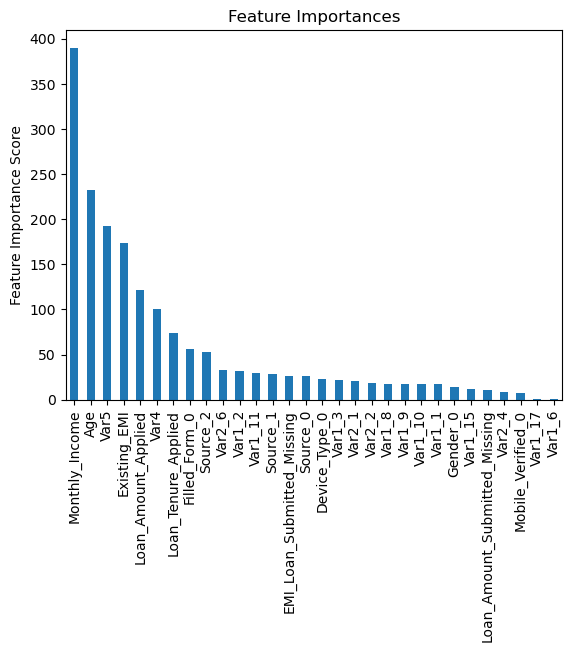

In [10]:
predictors = [x for x in X_train.columns if x not in [target, IDcol]]

modelfit(model_xgb, X_train, X_test, predictors)

Перебираем max_depth и min_child_weight по сетке.

In [11]:
from sklearn.model_selection import GridSearchCV

param_test1 = {"max_depth": range(2, 7, 2), "min_child_weight": range(1, 6, 2)}

gsearch1 = GridSearchCV(
    estimator=model_xgb, param_grid=param_test1, scoring="roc_auc", n_jobs=-1, cv=5
)

gsearch1.fit(X_train[predictors], X_train[target])

gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 4, 'min_child_weight': 5}, 0.8274289090608191)

Уточняем предсказание

In [12]:
param_test2 = {"max_depth": [3, 4, 5], "min_child_weight": [2, 3, 4]}

gsearch2 = GridSearchCV(
    estimator=model_xgb, param_grid=param_test2, scoring="roc_auc", n_jobs=-1, cv=5
)

gsearch2.fit(X_train[predictors], X_train[target])
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 5, 'min_child_weight': 3}, 0.828948217260183)

Зафиксируем найденный max_depth и min_child_weight

In [13]:
model_xgb.max_depth = 5
model_xgb.min_child_weight = 3

Мы подобрали max_depth и min_child_weight - дальше будем использовать подобранные значения параметров. Подберите по сетке параметр gamma на отрезке от 0 до 1.

In [14]:
param_test3 = {
    'gamma': # your code here
}

gsearch3b = # your code here

gsearch3b.fit(X_train[predictors], X_train[target])

SyntaxError: expression expected after dictionary key and ':' (674615411.py, line 2)

In [ ]:
gsearch3b.best_params_, gsearch3b.best_score_

Установите в качестве параметра алгоритма подобранyю gamma и посмотрите как изменилось качество.

In [ ]:
predictors = [x for x in X_train.columns if x not in [target, IDcol]]

# your code here

modelfit(model_xgb, X_train, X_test, predictors)

Подберите по сетке параметры subsample и colsample_bytree. Используйте значения этих параметров: [0.6, 0.7, 0.8, 0.9, 1.]

In [ ]:
# your code here

Подберите параметр регуляризации reg_alpha. Попробуйте [1e-5, 1e-2, 0.1, 1, 100]

In [ ]:
# your code here

Запустите обучение и предсказание на найденных параметрах и посмотрите на качество.

In [ ]:
# your code here

modelfit(model_xgb, X_train, X_test, predictors)

Уменьшите learning_rate до 0.01 и пропорционально увеличьте число деревьев. Все подобранные параметры остаются такими же. Обучите модель и сделайте предсказание. Посмотрите на качество.

In [ ]:
# Your code here

modelfit(model_xgb, X_train, X_test, predictors)

## 2. CatBoost

Ноутбук из официальной документации здесь: https://github.com/catboost/tutorials/blob/master/classification/classification_tutorial.ipynb

Особенности катбуста:

* используются симметричные деревья решений

* для кодирования категориальных признаков используется большой набор методов

* динамический бустинг 

Благодаря использованию симметричных деревьев и динамическому бустингу катбуст гораздо более устойчив к переобучению, чем другие имплементации градиентного бустинга. Поэтому он показывает хорошее качество даже при дефолтных параметрах.

Посмотреть видео про катбуст: https://yandex.ru/video/preview/?filmId=10919886479285152550&from=tabbar&text=catboost+анна+вероника

Устанавливаем библиотеки

In [18]:
!pip install --upgrade catboost
!pip install --upgrade ipywidgets
!pip install shap
!pip install sklearn
!pip install --upgrade numpy
!jupyter nbextension enable --py widgetsnbextension

   ---------------------------------------- 0.0/101.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/101.1 MB 682.7 kB/s eta 0:02:29
   ---------------------------------------- 0.1/101.1 MB 825.8 kB/s eta 0:02:03
   ---------------------------------------- 0.1/101.1 MB 980.4 kB/s eta 0:01:44
   ---------------------------------------- 0.2/101.1 MB 1.1 MB/s eta 0:01:37
   ---------------------------------------- 0.2/101.1 MB 1.0 MB/s eta 0:01:39
   ---------------------------------------- 0.3/101.1 MB 1.1 MB/s eta 0:01:32
   ---------------------------------------- 0.3/101.1 MB 1.1 MB/s eta 0:01:32
   ---------------------------------------- 0.4/101.1 MB 1.1 MB/s eta 0:01:30
   ---------------------------------------- 0.5/101.1 MB 1.2 MB/s eta 0:01:26
   ---------------------------------------- 0.5/101.1 MB 1.2 MB/s eta 0:01:25
   ---------------------------------------- 0.6/101.1 MB 1.2 MB/s eta 0:01:24
   ---------------------------------------- 0.7/101.1 MB 1.3 MB/s

DEPRECATION: Loading egg at c:\programdata\anaconda3\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


   ---------------------------------------- 0.0/139.4 kB ? eta -:--:--
   ----- --------------------------------- 20.5/139.4 kB 330.3 kB/s eta 0:00:01
   ----------------- --------------------- 61.4/139.4 kB 656.4 kB/s eta 0:00:01
   ------------------------------------ - 133.1/139.4 kB 983.0 kB/s eta 0:00:01
   -------------------------------------- 139.4/139.4 kB 916.1 kB/s eta 0:00:00
   ---------------------------------------- 0.0/214.4 kB ? eta -:--:--
   ----------------- ---------------------- 92.2/214.4 kB 2.6 MB/s eta 0:00:01
   ------------------------------ --------- 163.8/214.4 kB 2.0 MB/s eta 0:00:01
   ---------------------------------------- 214.4/214.4 kB 1.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   - -------------------------------------- 0.1/2.3 MB 1.7 MB/s eta 0:00:02
   -- ------------------------------------- 0.1/2.3 MB 1.4 MB/s eta 0:00:02
   --- ------------------------------------ 0.2/2.3 MB 1.4 MB/s eta 0:00:02
  

DEPRECATION: Loading egg at c:\programdata\anaconda3\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


   ---------------------------------------- 0.0/455.5 kB ? eta -:--:--
   -- ------------------------------------ 30.7/455.5 kB 660.6 kB/s eta 0:00:01
   -------- ------------------------------- 92.2/455.5 kB 1.1 MB/s eta 0:00:01
   -------------- ------------------------- 163.8/455.5 kB 1.2 MB/s eta 0:00:01
   ------------------- -------------------- 225.3/455.5 kB 1.3 MB/s eta 0:00:01
   ------------------------- -------------- 286.7/455.5 kB 1.3 MB/s eta 0:00:01
   ------------------------------- -------- 358.4/455.5 kB 1.4 MB/s eta 0:00:01
   ------------------------------------ --- 419.8/455.5 kB 1.4 MB/s eta 0:00:01
   ---------------------------------------- 455.5/455.5 kB 1.3 MB/s eta 0:00:00


DEPRECATION: Loading egg at c:\programdata\anaconda3\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


DEPRECATION: Loading egg at c:\programdata\anaconda3\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [15 lines of output]
  The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
  rather than 'sklearn' for pip commands.
  
  Here is how to fix this error in the main use cases:
  - use 'pip install scikit-learn' rather than 'pip install sklearn'
  - replace 'sklearn' by 'scikit-learn' in your pip requirements files
    (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
  - if the 'sklearn' package is used by one of your dependencies,
    it would be great if you take some time to track which package uses
    'sklearn' instead of 'scikit-learn' and report it to their issue tracker


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'
  Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl (15.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3


DEPRECATION: Loading egg at c:\programdata\anaconda3\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.0 requires FuzzyTM>=0.4.0, which is not installed.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.
tables 3.8.0 requires cython>=0.29.21, which is not installed.
numba 0.57.1 requires numpy<1.25,>=1.21, but you have numpy 1.26.4 which is incompatible.
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [19]:
from matplotlib import pylab as plt

%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [20]:
import os

import numpy as np
import pandas as pd

np.set_printoptions(precision=4)
import catboost
from catboost import *
from catboost import datasets

Считываем данные. Данные содержат только категориальные признаки, причем с большим количеством категорий. Признаки - закодированные характеристики сотрудника и некоторого ресурса, целевая переменная - есть ли у сотрудника доступ к ресурсу.

In [21]:
(train_df, test_df) = catboost.datasets.amazon()

In [22]:
train_df.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


Готовим данные

In [23]:
y = train_df.ACTION
X = train_df.drop("ACTION", axis=1)

Создаем список категориальных фичей

In [24]:
cat_features = list(range(0, X.shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8]


Смотрим на соотношение классов

In [25]:
print("Labels: {}".format(set(y)))
print("Zero count = {}, One count = {}".format(len(y) - sum(y), sum(y)))

Labels: {0, 1}
Zero count = 1897, One count = 30872


В catboost используется абстракция Pool - это объект, который содержит матрицу объект-признак X, вектор ответов, список номеров колонок с категориальными признаками.

In [26]:
pool1 = Pool(data=X, label=y, cat_features=cat_features)

pool2 = Pool(data=X, cat_features=cat_features)

# Fastest way to create a Pool is to create it from numpy matrix.
# This way should be used if you want fast predictions
# or fastest way to load the data in python.

X_prepared = X.values.astype(str).astype(object)
# For FeaturesData class categorial features must have type str

pool3 = Pool(
    data=FeaturesData(cat_feature_data=X_prepared, cat_feature_names=list(X)),
    label=y.values,
)

print("Dataset shape")
print(
    "dataset 1:"
    + str(pool1.shape)
    + "\ndataset 2:"
    + str(pool2.shape)
    + "\ndataset 3: "
    + str(pool3.shape)
)

print("\n")
print("Column names")
print("dataset 1:")
print(pool1.get_feature_names())
print("\ndataset 2:")
print(pool2.get_feature_names())
print("\ndataset 3:")
print(pool3.get_feature_names())

Dataset shape
dataset 1:(32769, 9)
dataset 2:(32769, 9)
dataset 3: (32769, 9)


Column names
dataset 1:
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']

dataset 2:
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']

dataset 3:
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']


Разбиваем данные на train и validation

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(
    X, y, train_size=0.8, random_state=42
)

Выбираем функцию потерь

Для бинарной классификации можем использовать:

* `Logloss`

* `CrossEntropy`

In [28]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(iterations=10, learning_rate=0.1)
model.fit(
    X_train,
    y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
)
print("Model is fitted: " + str(model.is_fitted()))
print("Model params:")
print(model.get_params())

Model is fitted: True
Model params:
{'iterations': 10, 'learning_rate': 0.1}


Печать результатов

In [29]:
model.fit(
    X_train,
    y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
)

0:	learn: 0.6189879	test: 0.6185816	best: 0.6185816 (0)	total: 34ms	remaining: 306ms
1:	learn: 0.5585149	test: 0.5574616	best: 0.5574616 (1)	total: 81.4ms	remaining: 326ms
2:	learn: 0.5082799	test: 0.5069499	best: 0.5069499 (2)	total: 106ms	remaining: 248ms
3:	learn: 0.4660897	test: 0.4643558	best: 0.4643558 (3)	total: 150ms	remaining: 224ms
4:	learn: 0.4304632	test: 0.4282709	best: 0.4282709 (4)	total: 211ms	remaining: 211ms
5:	learn: 0.4002849	test: 0.3979354	best: 0.3979354 (5)	total: 252ms	remaining: 168ms
6:	learn: 0.3745697	test: 0.3720454	best: 0.3720454 (6)	total: 269ms	remaining: 115ms
7:	learn: 0.3525686	test: 0.3498882	best: 0.3498882 (7)	total: 287ms	remaining: 71.7ms
8:	learn: 0.3336944	test: 0.3308677	best: 0.3308677 (8)	total: 297ms	remaining: 33ms
9:	learn: 0.3174817	test: 0.3145131	best: 0.3145131 (9)	total: 309ms	remaining: 0us

bestTest = 0.3145131058
bestIteration = 9



Визуализация метрик

In [30]:
model.fit(
    X_train,
    y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Сравнение моделей

In [31]:
model1 = CatBoostClassifier(
    learning_rate=0.1, iterations=100, random_seed=0, train_dir="learing_rate_0.1"
)

model2 = CatBoostClassifier(
    learning_rate=0.07, iterations=100, random_seed=0, train_dir="learing_rate_0.07"
)
model1.fit(
    X_train,
    y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False,
)
model2.fit(
    X_train,
    y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False,
)

In [ ]:
from catboost import MetricVisualizer

MetricVisualizer(["learing_rate_0.01", "learing_rate_0.7"]).start()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Оптимальное количество деревьев

In [ ]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(
    iterations=100,
    random_seed=63,
    learning_rate=0.5,
    #     use_best_model=False
)
model.fit(
    X_train,
    y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True,
)

In [ ]:
print("Tree count: " + str(model.tree_count_))

Кросс-валидация

In [ ]:
from catboost import cv

params = {}
params["loss_function"] = "Logloss"
params["iterations"] = 80
params["custom_loss"] = "AUC"
params["random_seed"] = 63
params["learning_rate"] = 0.5

cv_data = cv(
    params=params,
    pool=Pool(X, label=y, cat_features=cat_features),
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=False,
    verbose=False,
)

In [ ]:
cv_data.head()

In [ ]:
best_value = np.min(cv_data["test-Logloss-mean"])
best_iter = np.argmin(cv_data["test-Logloss-mean"])

print(
    "Best validation LogLoss score, not stratified: {:.4f}±{:.4f} on step {}".format(
        best_value, cv_data["test-Logloss-std"][best_iter], best_iter
    )
)

Детектор переобучения

In [ ]:
model_with_early_stop = CatBoostClassifier(
    iterations=200, random_seed=63, learning_rate=0.5, early_stopping_rounds=20
)
model_with_early_stop.fit(
    X_train,
    y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True,
)

In [ ]:
print(model_with_early_stop.tree_count_)

In [ ]:
model_with_early_stop = CatBoostClassifier(
    eval_metric="AUC",
    iterations=200,
    random_seed=63,
    learning_rate=0.5,
    early_stopping_rounds=20,
)
model_with_early_stop.fit(
    X_train,
    y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True,
)

In [ ]:
print(model_with_early_stop.tree_count_)

Вычисление метрик качества и выбор порога принятия решения

In [ ]:
model = CatBoostClassifier(
    random_seed=63,
    iterations=200,
    learning_rate=0.03,
)
model.fit(X_train, y_train, cat_features=cat_features, verbose=False, plot=True)

![](https://habrastorage.org/webt/y4/1q/yq/y41qyqfm9mcerp2ziys48phpjia.png)

In [ ]:
import sklearn
from catboost.utils import get_roc_curve
from sklearn import metrics

eval_pool = Pool(X_validation, y_validation, cat_features=cat_features)
curve = get_roc_curve(model, eval_pool)
(fpr, tpr, thresholds) = curve
roc_auc = sklearn.metrics.auc(fpr, tpr)

In [ ]:
plt.figure(figsize=(16, 8))
lw = 2

plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
    alpha=0.5,
)

plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--", alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel("False Positive Rate", fontsize=16)
plt.ylabel("True Positive Rate", fontsize=16)
plt.title("Receiver operating characteristic", fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [ ]:
from catboost.utils import get_fnr_curve, get_fpr_curve

(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

In [ ]:
plt.figure(figsize=(16, 8))
lw = 2

plt.plot(thresholds, fpr, color="blue", lw=lw, label="FPR", alpha=0.5)
plt.plot(thresholds, fnr, color="green", lw=lw, label="FNR", alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel("Threshold", fontsize=16)
plt.ylabel("Error Rate", fontsize=16)
plt.title("FPR-FNR curves", fontsize=20)
plt.legend(loc="lower left", fontsize=16)
plt.show()

In [ ]:
from catboost.utils import select_threshold

print(select_threshold(model=model, data=eval_pool, FNR=0.01))
print(select_threshold(model=model, data=eval_pool, FPR=0.01))

Получение предсказаний

In [ ]:
print(model.predict_proba(X_validation))

In [ ]:
print(model.predict(X_validation))

Последовательные предсказания

In [ ]:
predictions_gen = model.staged_predict_proba(
    data=X_validation, ntree_start=0, ntree_end=5, eval_period=1
)
try:
    for iteration, predictions in enumerate(predictions_gen):
        print("Iteration " + str(iteration) + ", predictions:")
        print(predictions)
except Exception:
    pass

Важность признаков

In [ ]:
model.get_feature_importance(prettified=True)

### Shap values 

Классические способы измерения важности признаков обладают существенным недостатком: непонятно, как именно каждый признак влияет на предсказание модели. Shap values (значения Шэпли) - способ измерения важности признаков, исправляющий этот недостаток.

Подробнее читайте тут: https://habr.com/ru/post/428213/

In [ ]:
import shap

shap_values = model.get_feature_importance(pool1, type="ShapValues")

expected_value = shap_values[0, -1]
shap_values = shap_values[:, :-1]

print(shap_values.shape)

In [ ]:
shap.summary_plot(shap_values, X)

Shap-values для конкретного объекта.

In [ ]:
shap.initjs()
shap.force_plot(expected_value, shap_values[3, :], X.iloc[3, :])

Сохранение модели

In [ ]:
my_best_model = CatBoostClassifier(iterations=10)
my_best_model.fit(
    X_train,
    y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False,
)
my_best_model.save_model("catboost_model.bin")
my_best_model.save_model("catboost_model.json", format="json")

In [ ]:
my_best_model.load_model("catboost_model.bin")
print(my_best_model.get_params())
print(my_best_model.random_seed_)

Подбор гиперпараметров

In [ ]:
cat = CatBoostClassifier(n_estimators=50)

grid = {"learning_rate": [0.03, 0.1], "depth": [4, 6, 10]}
#        'l2_leaf_reg': [1, 3, 5, 7, 9]}

grid_search_result = cat.grid_search(
    grid, X=X_train, y=y_train, verbose=False, plot=True
)

In [ ]:
grid_search_result["params"]

Визуализация деревьев

In [ ]:
# Might run into the graphiz problem:
# https://stackoverflow.com/questions/35064304/runtimeerror-make-sure-the-graphviz-executables-are-on-your-systems-path-aft

In [ ]:
cat.plot_tree(tree_idx=0)

Хорошее описание гиперпараметров катбуста: https://habr.com/ru/company/otus/blog/527554/

## LightGBM

Особенности LightGBM:

* полиственное (leaf-wise), а не поуровневое (depth-wise) построение деревьев

* быстрое построение дерева, позволяющее не кодировать категориальные признаки, а использовать исходные категории для получения предикатов

* ускорение построения деревьев за счёт бинаризации признаков (объединение значений признака в группы)

Почитать подробнее можно тут: https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc

In [ ]:
# !conda install lightgbm --y

# For those who strugle with M1/M2 macs:
# !arch -arm64 brew install libomp

In [ ]:
import lightgbm as lgb
import numpy as np
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split

data = load_boston()
X_full = data.data
y_full = data.target

X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=100, random_state=241
)

Обучение

In [ ]:
print("Starting training...")
# train
gbm = lgb.LGBMRegressor(num_leaves=31, learning_rate=0.05, n_estimators=20)
gbm.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="l1",
    early_stopping_rounds=5,
)

Предсказание и оценка качества

In [ ]:
print("Starting predicting...")

y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)

print("The rmse of prediction is:", mean_squared_error(y_test, y_pred) ** 0.5)

# feature importances
print("Feature importances:", list(gbm.feature_importances_))

Можно задать любую (придумать свою, например) метрику качества

In [ ]:
# self-defined eval metric
# f(y_true: array, y_pred: array) -> name: string, eval_result: float, is_higher_better: bool
# Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(y_true, y_pred):
    return (
        "RMSLE",
        np.sqrt(np.mean(np.power(np.log1p(y_pred) - np.log1p(y_true), 2))),
        False,
    )


print("Starting training with custom eval function...")
# train
gbm.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    eval_metric=rmsle,
    early_stopping_rounds=5,
)

print("Starting predicting...")
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
# eval
print("The rmsle of prediction is:", rmsle(y_test, y_pred)[1])

Подбор гиперпараметров

In [ ]:
# other scikit-learn modules
estimator = lgb.LGBMRegressor(num_leaves=31)

param_grid = {"learning_rate": [0.01, 0.1, 1], "n_estimators": [20, 40]}

gbm = GridSearchCV(estimator, param_grid, cv=3)
gbm.fit(X_train, y_train)

print("Best parameters found by grid search are:", gbm.best_params_)

Предсказание и оценка качества

In [ ]:
pred = gbm.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, pred)